# Load Model

In [50]:
import os
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
mean, std = [0.4914, 0.4822, 0.4465 ], [ 0.2023, 0.1994, 0.2010 ], 

train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])


cifar10_train = dsets.CIFAR10(root='./data', train=True,
                                       download=True, transform=train_transform)
cifar10_test  = dsets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=50,
                                         shuffle=True, num_workers=1)

test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=50,
                                        shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (20, 50))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

# modules

In [3]:
def generate_opt_means(C, p, L): 
    """
    input
        C = constant value
        p = dimention of feature vector
        L = class number
    """
    opt_means = np.zeros((L, p))
    opt_means[0][0] = 1
    for i in range(1,L):
        for j in range(i): 
            opt_means[i][j] = - (1/(L-1) + np.dot(opt_means[i],opt_means[j])) / opt_means[j][j]
        opt_means[i][i] = np.sqrt(1 - np.linalg.norm(opt_means[i])**2)
    for k in range(L):
        opt_means[k] = C * opt_means[k]
        
    return opt_means

In [4]:
class MM_LDA(nn.Module):
    def __init__(self, C, n_dense, class_num, device, Normalize=False):
        super().__init__()
        self.C = C
        self.class_num = class_num
        opt_means = generate_opt_means(C, n_dense, class_num)
        self.mean_expand = torch.tensor(opt_means).unsqueeze(0).double().to(device) # (1, num_class, num_dense)
        self.Normalize = Normalize
        
    def forward(self, x):
#         print('x', x, x.shape)
        b, p = x.shape # batch_size, num_dense
        L = self.class_num
        if self.Normalize: # 正規化する
            x = (x / (torch.norm(x, p=2, dim=1, keepdim=True) + 1e-10)) * self.C
#             print(torch.norm(x, p=2, dim=1, keepdim=True))
            
        x_expand =  x.repeat(1,L).view(b, L, p).double() # (batch_size, num_class, num_dense)

        logits = - torch.sum((x_expand - self.mean_expand)**2, dim=2) # (batch_size, num_class)
#         print('x-mean',x_expand - self.mean_expand)
#         print('logits', logits, logits.shape)
 
        return logits

In [63]:
class dot_loss(nn.Module):
    def __init__(self):
        super(dot_loss, self).__init__()

    def forward(self, y_pred, y_true):
        y_pred = y_pred.double()
        y_true = F.one_hot(y_true, num_classes=y_pred.size(1)).double()
        loss = - torch.sum(y_pred * y_true, dim=1) #batch_size X 1
#         print('y_pred, y_true, loss',y_pred, y_true, loss.sum())
        return loss.mean()

# Attacks

In [48]:
class FGSM(object):
    def __init__(self, model, criterion, eps, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.eps = eps
        self.device = device
        
    def __call__(self, images, labels):
        images = images.to(self.device)
        labels = labels.to(self.device)

        images.requires_grad = True
        outputs = self.model(images)
        loss = self.criterion(outputs, labels).to(device)

        grad = torch.autograd.grad(loss, images,
                                   retain_graph=False, create_graph=False)[0]

        adv_images = images + self.eps*grad.sign()
        adv_images = adv_images.detach()

        return adv_images

In [49]:
class PGD(object):
    def __init__(self, model, criterion, eps, alpha=2/255, steps=10, random_start=False, 
                 targeted=False, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.targeted = targeted
        self.sign = 1
        if targeted:
            self.sign = -1
        self.device = device
        
    def __call__(self, images, labels):
        images = images.to(self.device)
        labels = labels.to(self.device)
        
        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
            adv_images = torch.clamp(adv_images, min=0, max=1)

        for i in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.model(adv_images)

            loss = self.sign*self.criterion(outputs, labels).to(self.device)

            grad = torch.autograd.grad(loss, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            adv_images = adv_images.detach() + self.alpha*grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = (images + delta).detach()

        return adv_images

# Test Code

In [5]:
def test_on_normal_data(model):
    model.eval()

    correct = 0
    total = 0

    for images, labels in test_loader:

        images = images.cuda()
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Accuracy of Clean images: %f %%' % (100 * float(correct) / total))

In [54]:
def test_on_AEs(model, attack_func):
    model.eval()

    correct = 0
    total = 0

    for images, labels in test_loader:

        adv_images = attack_func(images, labels ).cuda()
        outputs = model(adv_images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Accuracy on Adversarial images: %f %%' % (100 * float(correct) / total))

In [53]:
def show_examples(model, attack_func):
    images, labels = iter(test_loader).next()
    t = 20
    idx = list(range(t,t+8))

    print('Normal')
    imshow(torchvision.utils.make_grid(images[idx], normalize=True), [classes[int(i)] for i in labels[idx]])
    _ , pred_labels = torch.max(model(images.cuda()), 1)
    print('Predicted Label:', [classes[int(i)] for i in pred_labels[idx]])

    print('------------------------------------')

    adv_images = attack_func(images, labels )

    print('Adversarial:', attack)
    imshow(torchvision.utils.make_grid(adv_images.cpu().data[idx], normalize=True), [classes[int(i)] for i in labels[idx]])

    outputs = model(adv_images.cuda())
    _, pred_labels = torch.max(outputs, 1)

    print('Predicted Label:', [classes[int(i)] for i in pred_labels[idx]])

# Test !

## 1. MMC

In [51]:
# MMC

file_name = './exps/checkpoint_resnet34_MMC/ckpt.pth'

model = models.resnet34(pretrained=False)
model.fc = nn.Linear(512,256) # use_dense
# MM_LDA 
C, n_dense, class_num = 10, 256, 10
mm_lda_layer = MM_LDA(C, n_dense, class_num, device, Normalize=True) 
#activation = nn.Softmax(1)
model = nn.Sequential(model, mm_lda_layer) # , activation) # テスト時はsoftmaxするため
model = model.to(device)

checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state_dict'])

criterion = dot_loss()

Accuracy of Clean images: 80.680000 %
FGSM
Accuracy on Adversarial images: 43.100000 %
Normal


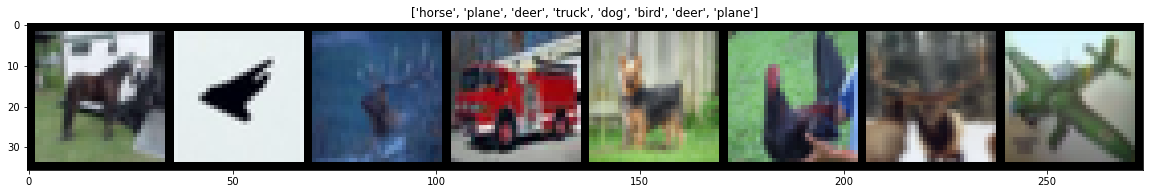

Predicted Label: ['horse', 'plane', 'deer', 'truck', 'deer', 'bird', 'deer', 'deer']
------------------------------------
Adversarial: FGSM


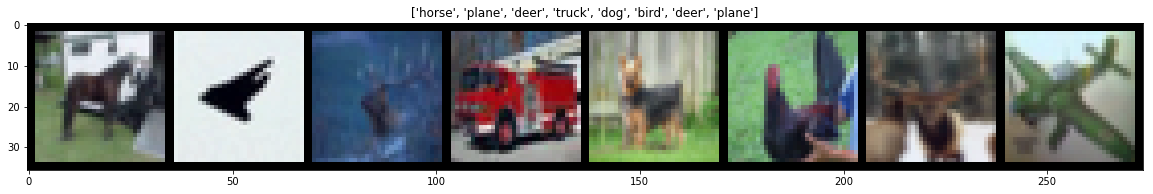

Predicted Label: ['car', 'bird', 'plane', 'truck', 'deer', 'cat', 'dog', 'deer']
FGSM
Accuracy on Adversarial images: 26.610000 %
Normal


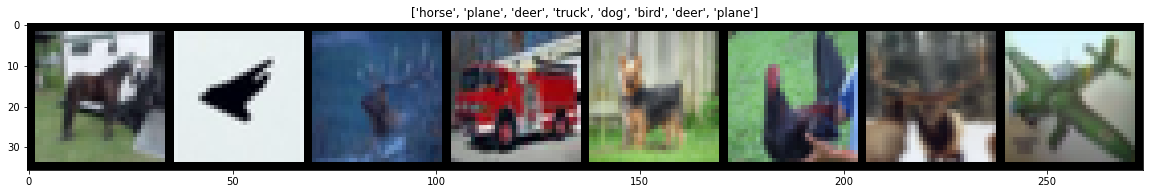

Predicted Label: ['horse', 'plane', 'deer', 'truck', 'deer', 'bird', 'deer', 'deer']
------------------------------------
Adversarial: FGSM


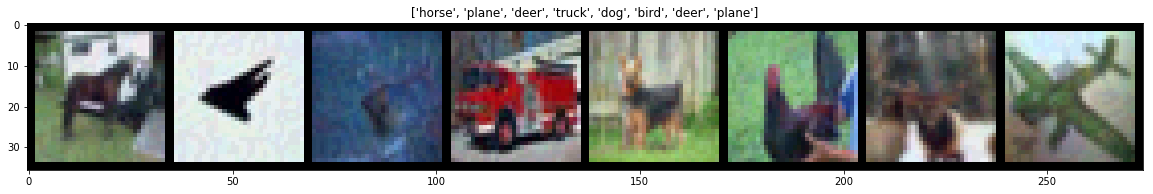

Predicted Label: ['car', 'bird', 'plane', 'car', 'deer', 'cat', 'dog', 'deer']


In [57]:
attacks = {'PGD':PGD(model, criterion, 8/255),
          'FGSM':FGSM(model, criterion, 0.12)}

test_on_normal_data(model)
for att_name in ['PGD','FGSM']:
    print(att_name)
    test_on_AEs(model, attacks[att_name])
    show_examples(model, attacks[att_name])

## 2.MM_LDA

In [59]:
# MM_LDA

file_name = './exps/checkpoint_resnet34_MMLDA/ckpt.pth'

model = models.resnet34(pretrained=False)
model.fc = nn.Linear(512,256) # use_dense
# MM_LDA 
C, n_dense, class_num = 100, 256, 10
mm_lda_layer = MM_LDA(C, n_dense, class_num, device, Normalize=True) 
#activation = nn.Softmax(1)
model = nn.Sequential(model, mm_lda_layer) # , activation) # テスト時はsoftmaxするため
model = model.to(device)

checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state_dict'])

criterion = dot_loss()

Accuracy of Clean images: 62.290000 %
PGD
Accuracy on Adversarial images: 26.460000 %
Normal


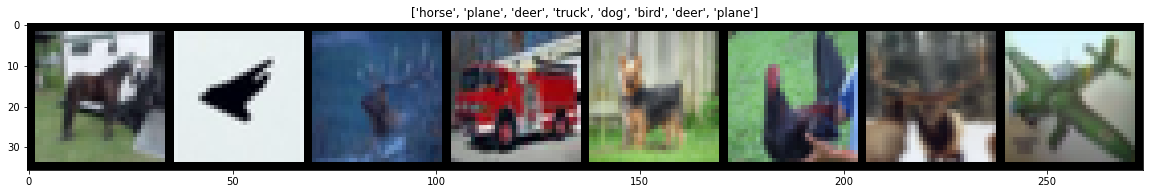

Predicted Label: ['horse', 'plane', 'bird', 'truck', 'deer', 'bird', 'deer', 'horse']
------------------------------------
Adversarial: FGSM


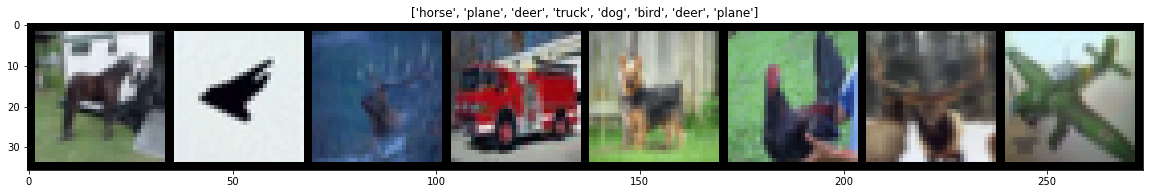

Predicted Label: ['truck', 'bird', 'ship', 'truck', 'deer', 'bird', 'deer', 'horse']
FGSM
Accuracy on Adversarial images: 12.160000 %
Normal


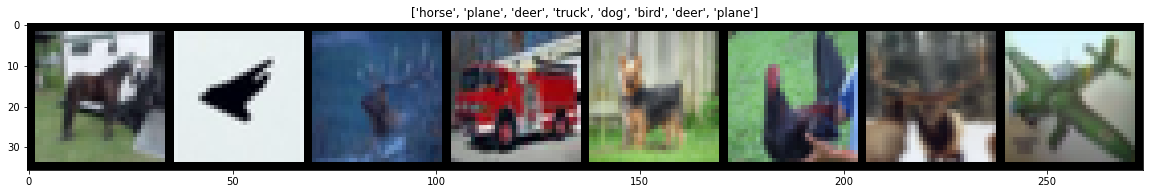

Predicted Label: ['horse', 'plane', 'bird', 'truck', 'deer', 'bird', 'deer', 'horse']
------------------------------------
Adversarial: FGSM


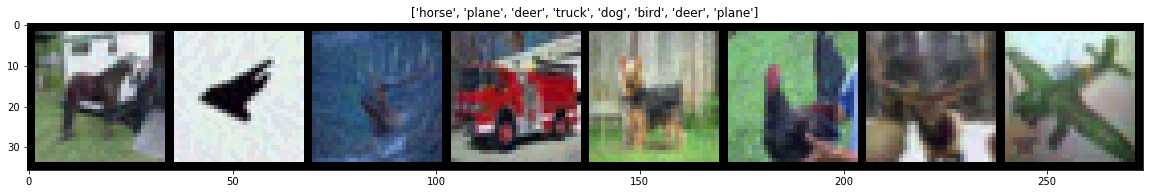

Predicted Label: ['car', 'bird', 'ship', 'truck', 'deer', 'bird', 'cat', 'horse']


In [60]:
attacks = {'PGD':PGD(model, criterion, 8/255),
          'FGSM':FGSM(model, criterion, 0.12)}

test_on_normal_data(model)
for att_name in ['PGD','FGSM']:
    print(att_name)
    test_on_AEs(model, attacks[att_name])
    show_examples(model, attacks[att_name])

# 3. SCE

In [61]:
file_name = './exps/checkpoint_resnet34/ckpt.pth'
model = models.resnet34(pretrained=False)
model.fc = nn.Linear(512,10) #for CIFAR10
model = model.to(device)

checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state_dict'])

criterion = nn.CrossEntropyLoss()

Accuracy of Clean images: 86.540000 %
PGD
Accuracy on Adversarial images: 41.850000 %
Normal


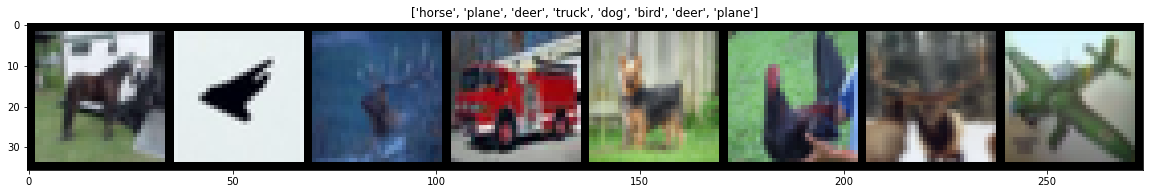

Predicted Label: ['car', 'plane', 'deer', 'truck', 'dog', 'bird', 'deer', 'plane']
------------------------------------
Adversarial: FGSM


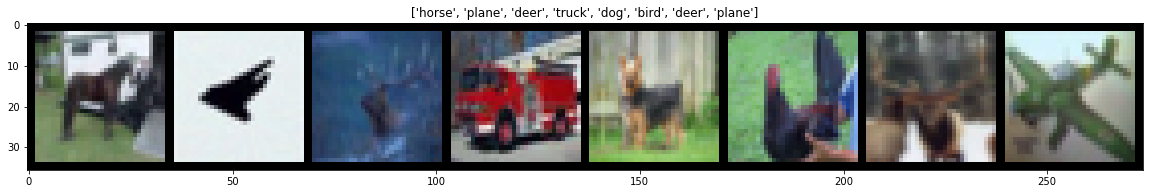

Predicted Label: ['car', 'plane', 'plane', 'truck', 'deer', 'dog', 'horse', 'plane']
FGSM


In [ ]:
attacks = {'PGD':PGD(model, criterion, 8/255),
          'FGSM':FGSM(model, criterion, 0.12)}

test_on_normal_data(model)
for att_name in ['PGD','FGSM']:
    print(att_name)
    test_on_AEs(model, attacks[att_name])
    show_examples(model, attacks[att_name])